# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')


from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

In [3]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081)) #TODO: CHECK THIS
])

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=64, shuffle=False)

# Define Model (40 Points)

[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

[Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

In [6]:
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )
        self.block5 = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=10)
        )

        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x) + x
        x = self.block3(x)
        x = self.block4(x) + x
        x = self.block5(x)
        return x

# Train Model (30 Points)

In [7]:
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
total_step = len(train_loader)
num_epochs = 20
best_model = None
min_val_loss = np.inf
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    count = 0
    corrects = 0
    for images, labels in tqdm(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model(images)
        labels_pred = y_pred.argmax(dim=1)
        corrects += labels_pred.eq(labels).sum().item()
        loss = criterion(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        count += images.shape[0]
    
    train_accuracy_list.append(corrects/count)
    train_loss_list.append(running_loss/count)
    print(f"Epoch {epoch}, Train Loss: {running_loss/count:.4f} Train Accuracy: {corrects/count:.4f}")
    

    with torch.no_grad():
        count = 0
        corrects = 0
        running_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            y_pred = model(images)
            labels_pred = y_pred.argmax(dim=1)
            loss = criterion(y_pred, labels)
            running_loss += loss.item()
            count += images.shape[0]
            corrects += labels_pred.eq(labels).sum().item()
        
        val_accuracy_list.append(corrects/count)
        val_loss_list.append(running_loss/count)
        if (running_loss/count) < min_val_loss:
            min_val_loss = running_loss/count
            best_model = model.state_dict()
        print(f"Epoch {epoch}, Validation Loss: {running_loss/count:.4f} Validation Accuracy: {corrects/count:.4f}")

100%|██████████| 782/782 [00:22<00:00, 35.45it/s]


Epoch 0, Train Loss: 0.0075 Train Accuracy: 0.8399
Epoch 0, Validation Loss: 0.0024 Validation Accuracy: 0.9530


100%|██████████| 782/782 [00:16<00:00, 48.39it/s]


Epoch 1, Train Loss: 0.0020 Train Accuracy: 0.9603
Epoch 1, Validation Loss: 0.0017 Validation Accuracy: 0.9684


100%|██████████| 782/782 [00:16<00:00, 46.33it/s]


Epoch 2, Train Loss: 0.0014 Train Accuracy: 0.9723
Epoch 2, Validation Loss: 0.0013 Validation Accuracy: 0.9751


100%|██████████| 782/782 [00:16<00:00, 47.81it/s]


Epoch 3, Train Loss: 0.0011 Train Accuracy: 0.9782
Epoch 3, Validation Loss: 0.0010 Validation Accuracy: 0.9794


100%|██████████| 782/782 [00:16<00:00, 46.28it/s]


Epoch 4, Train Loss: 0.0009 Train Accuracy: 0.9825
Epoch 4, Validation Loss: 0.0009 Validation Accuracy: 0.9819


100%|██████████| 782/782 [00:16<00:00, 47.11it/s]


Epoch 5, Train Loss: 0.0008 Train Accuracy: 0.9846
Epoch 5, Validation Loss: 0.0009 Validation Accuracy: 0.9821


100%|██████████| 782/782 [00:17<00:00, 44.15it/s]


Epoch 6, Train Loss: 0.0006 Train Accuracy: 0.9865
Epoch 6, Validation Loss: 0.0009 Validation Accuracy: 0.9849


100%|██████████| 782/782 [00:16<00:00, 47.41it/s]


Epoch 7, Train Loss: 0.0006 Train Accuracy: 0.9889
Epoch 7, Validation Loss: 0.0005 Validation Accuracy: 0.9890


100%|██████████| 782/782 [00:17<00:00, 44.23it/s]


Epoch 8, Train Loss: 0.0005 Train Accuracy: 0.9896
Epoch 8, Validation Loss: 0.0006 Validation Accuracy: 0.9886


100%|██████████| 782/782 [00:17<00:00, 44.38it/s]


Epoch 9, Train Loss: 0.0005 Train Accuracy: 0.9906
Epoch 9, Validation Loss: 0.0007 Validation Accuracy: 0.9876


100%|██████████| 782/782 [00:18<00:00, 43.38it/s]


Epoch 10, Train Loss: 0.0004 Train Accuracy: 0.9914
Epoch 10, Validation Loss: 0.0005 Validation Accuracy: 0.9895


100%|██████████| 782/782 [00:16<00:00, 47.05it/s]


Epoch 11, Train Loss: 0.0003 Train Accuracy: 0.9931
Epoch 11, Validation Loss: 0.0011 Validation Accuracy: 0.9813


100%|██████████| 782/782 [00:16<00:00, 47.13it/s]


Epoch 12, Train Loss: 0.0003 Train Accuracy: 0.9935
Epoch 12, Validation Loss: 0.0005 Validation Accuracy: 0.9901


100%|██████████| 782/782 [00:16<00:00, 46.78it/s]


Epoch 13, Train Loss: 0.0003 Train Accuracy: 0.9944
Epoch 13, Validation Loss: 0.0005 Validation Accuracy: 0.9912


100%|██████████| 782/782 [00:17<00:00, 45.01it/s]


Epoch 14, Train Loss: 0.0003 Train Accuracy: 0.9947
Epoch 14, Validation Loss: 0.0005 Validation Accuracy: 0.9906


100%|██████████| 782/782 [00:17<00:00, 44.07it/s]


Epoch 15, Train Loss: 0.0002 Train Accuracy: 0.9953
Epoch 15, Validation Loss: 0.0005 Validation Accuracy: 0.9908


100%|██████████| 782/782 [00:21<00:00, 36.19it/s]


Epoch 16, Train Loss: 0.0002 Train Accuracy: 0.9951
Epoch 16, Validation Loss: 0.0005 Validation Accuracy: 0.9905


100%|██████████| 782/782 [00:18<00:00, 42.54it/s]


Epoch 17, Train Loss: 0.0002 Train Accuracy: 0.9967
Epoch 17, Validation Loss: 0.0005 Validation Accuracy: 0.9910


100%|██████████| 782/782 [00:17<00:00, 45.67it/s]


Epoch 18, Train Loss: 0.0002 Train Accuracy: 0.9957
Epoch 18, Validation Loss: 0.0005 Validation Accuracy: 0.9897


100%|██████████| 782/782 [00:17<00:00, 44.30it/s]


Epoch 19, Train Loss: 0.0002 Train Accuracy: 0.9965
Epoch 19, Validation Loss: 0.0009 Validation Accuracy: 0.9844


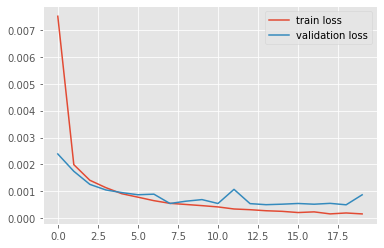

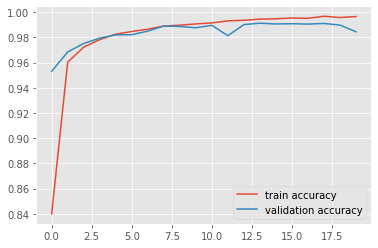

In [9]:
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.legend()
plt.show()


# Test Model (20 Points)

10000
Test Loss: 0.0007 Test Accuracy: 0.9869


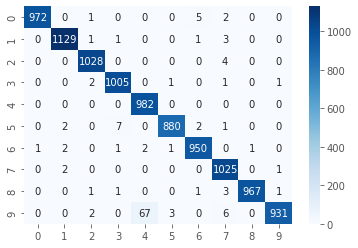

In [10]:

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))
all_labels = []
all_preds = []
with torch.no_grad():
    count = 0
    corrects = 0
    running_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model(images)
        labels_pred = y_pred.argmax(dim=1)
        loss = criterion(y_pred, labels)
        running_loss += loss.item()
        count += images.shape[0]
        corrects += labels_pred.eq(labels).sum().item()
        all_labels.extend(labels.cpu())
        all_preds.extend(labels_pred.cpu())
    
    print(f"Test Loss: {running_loss/count:.4f} Test Accuracy: {corrects/count:.4f}")
    cm = confusion_matrix(all_labels, all_preds)
    heatmap(cm, annot=True, fmt='d', cmap='Blues')

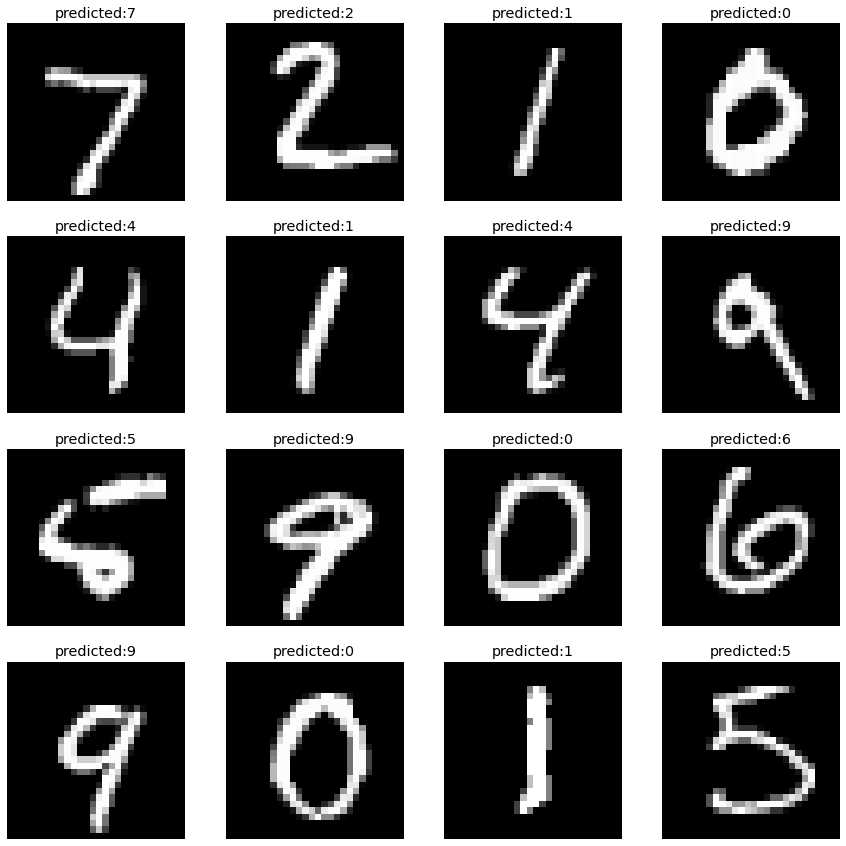

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#img = mpimg.imread('night.jpg')
#plt.imshow(img,cmap='gray')
#img = torch.tensor(img, dtype=torch.float)
rows = 4
columns = 4
plt.rcParams['figure.figsize'] = (15.0, 15.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

for i in range(rows*columns):
    img = test_loader.dataset.data[i].float()
    output = model(img.unsqueeze(0).unsqueeze(0).to(device)).argmax(dim=1).item()
    plt.subplot(rows, columns, i + 1)
    plt.title(f"predicted:{output}")
    plt.axis('off')
    plt.imshow(img)
plt.show()
